In [1]:
#this is a data cleaning jupyter notebook on horse racing data

import pandas as pd
import numpy as np
import regex
import time
import os
import seaborn as sns
%pwd

'/home/neilfa/jupyter_data_cleaning'

In [2]:
with open('/proc/meminfo') as file:
    for line in file:
        if 'MemFree' in line:
            free_mem_in_kb = line.split()[1]
            break
file_path = '2019_1_1-2020_1_1.csv' 
file_size = os.path.getsize(file_path)
            
start = time.time()
df = pd.read_csv(file_path)
end = time.time()
index = df.index
num_row = len(index)

print('It takes {0} seconds to load in {1} rows of data (size of the file is {2} bytes), with {3} memory available'.format((end-start),num_row,file_size,free_mem_in_kb))

It takes 0.20280909538269043 seconds to load in 31651 rows of data (size of the file is 14016826 bytes), with 14323388 memory available


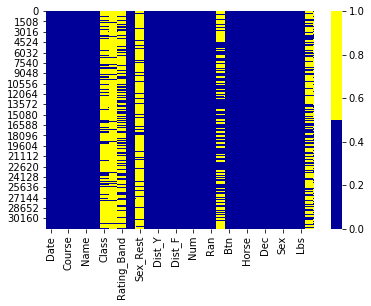

In [3]:
# missing values analysis

cols = df.columns[:30] # first 30
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#normal for class to have missing values as Ireland races don't have a class




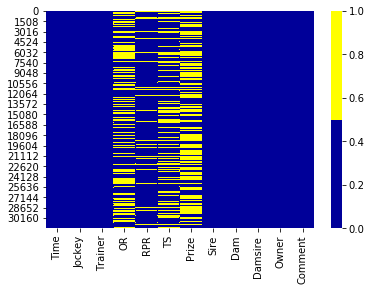

In [4]:

cols = df.columns[30:42] # last 12
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [4]:
# Gonna make a smaller dataframe (sm_df)
# Just to make it easier to work with

sm_df = df.loc[:,('Date','Name','Horse','Pos','SP','Ran','Time','RPR',)]
sm_df.head()

,Date,Name,Horse,Pos,SP,Ran,Time,RPR
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,3/1,15,5:1.80,127.0
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,8/1,15,5:4.20,111.0
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,10/11F,15,5:5.15,115.0
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,25/1,15,5:5.40,112.0
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,8/1,15,5:5.70,111.0


In [5]:
# sorting out the fractional odds to decimal odds, and having a new column saying if they are favourite
# decimal odds are easier to work with 
# decimal odds = numerator / denominator + 1

fodds = df.loc[:,'SP'] #fractional odds
fodds = fodds.str.replace("Evens","1/1")
fodds = fodds.str.replace("Evs","1/1")
splt = fodds.str.extract(r'(\d+).(\d+)(.?)')

splt.iloc[:,0] = splt.iloc[:,0].astype(float)
splt.iloc[:,1] = splt.iloc[:,1].astype(float)

dodds = (splt.iloc[:,0]/splt.iloc[:,1])+1 #decimal odds

odds_f = pd.concat([dodds,splt.iloc[:,2]],axis=1)

sm_df.loc[:,'SP'] = odds_f.iloc[:,0]
sm_df = pd.concat([sm_df,odds_f.iloc[:,1]],axis=1)


sm_df=sm_df.rename(columns={2:"Fav"})

#There are 3 possible letters that can come after the odds:
#F there is one favourite in the race (7/2F)
#J there are 2 favourite in the race (same odds) (7/2J,7/2J)
#C there are 3 favourite (3/1C,3/1C,3/1C)

#Instead of keeping the letters
#Gonna make a new column with series of bool - favorite TRUE or FALSE

sm_df.loc[:,"Fav"] = sm_df.loc[:,"Fav"].str.contains(r"\S") 

sm_df.head()





,Date,Name,Horse,Pos,SP,Ran,Time,RPR,Fav
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman (IRE),1,4.000000,15,5:1.80,127.0,False
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady (FR),2,9.000000,15,5:4.20,111.0,False
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus (IRE),3,1.909091,15,5:5.15,115.0,True
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill (IRE),4,26.000000,15,5:5.40,112.0,False
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner (IRE),5,9.000000,15,5:5.70,111.0,False


In [6]:
#New horse name with only the name
#New column with the horse's country

nme = sm_df.loc[:,'Horse']
splt = nme.str.extract(r"(.+)\s\((\w+)\)")
sm_df['Horse'] = splt.iloc[:,0]
sm_df['Horse_nation'] = splt.iloc[:,1]
sm_df.head(15)



,Date,Name,Horse,Pos,SP,Ran,Time,RPR,Fav,Horse_nation
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,5:1.80,127.0,False,IRE
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,5:4.20,111.0,False,FR
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,5:5.15,115.0,True,IRE
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,5:5.40,112.0,False,IRE
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,5:5.70,111.0,False,IRE
5,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,The Echo Boy,6,11.000000,15,5:11.30,85.0,False,IRE
6,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Galboystown Rose,7,101.000000,15,5:14.30,60.0,False,IRE
7,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Robbies Magic,8,101.000000,15,5:16.30,58.0,False,IRE
8,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Take A Turn,9,26.000000,15,5:17.10,51.0,False,IRE
9,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Goodkess,10,34.000000,15,5:24.50,17.0,False,IRE


In [7]:
#Now I need to convert time from string to actual time in seconds
#5:1.80 = 5min and 1.8 seconds
print(type(sm_df.loc[0,'Time']))
tme = sm_df['Time']
mtch = tme.str.extract(r"(\d+):(.+)")
mtch[0] = mtch[0].astype(float)
mtch[1] = mtch[1].astype(float)
sm_df['Time'] = (mtch[0]*60)+mtch[1]
#sm_df.iloc[[0,15],:]
sm_df.head()

<class 'str'>


,Date,Name,Horse,Pos,SP,Ran,Time,RPR,Fav,Horse_nation
0,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Swordsman,1,4.000000,15,301.80,127.0,False,IRE
1,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Westport Lady,2,9.000000,15,304.20,111.0,False,FR
2,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Momus,3,1.909091,15,305.15,115.0,True,IRE
3,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Tara Mill,4,26.000000,15,305.40,112.0,False,IRE
4,2019-01-01,Happy New Year from all at Fairyhouse Maiden H...,Impatient Partner,5,9.000000,15,305.70,111.0,False,IRE


In [16]:
#There is an important error to fix
#The name of a race might be duplicated ie, the same named race can occur on 2 different dates
#What needs to be done:
#1. Need to create a column identifying whether or not the race is a handicapped
    #creating a new bool series identicating whether the race is handicapped or not might be useful for analysis
#2. Create a new unique set of IDs for the race:
    # how to do this step I'm not sure

pattern = "andica"
sm_df['Handicap'] = sm_df['Name'].str.contains(pattern)

#total number of races group by date and name


grpDN = sm_df.groupby(['Date','Name'])
grpN = sm_df.groupby(['Name'])
print("there are {} races with the same name\ntotal number of races is {} in 2019".format((grpDN.ngroups-grpN.ngroups),grpDN.ngroups))


there are 392 races with the same name
total number of races is 2663 in 2019


In [ ]:
#Creating a Unique ID for each race (UID)
#year(2019) + the index number (could be alphabetical) not important as long as the UID

UID = list()
racesnu = grpDN.ngroups
for i in range(racesnu):
    UID.append('2019'+(str(i+1)))

#append value to a already excisting key
#https://thispointer.com/python-how-to-add-append-key-value-pairs-in-dictionary-using-dict-update/#:~:text=this'%3A%2043%7D-,Append%20multiple%20key%20value%20pair%20in%20dictionary,it%20will%20update%20its%20value.
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value    


#Going to append a list of UID that is the length of the number of horses that ran the race
#to each race which grouped into the dicG dictionary
#This doesn't work loop takes too long

#for key in dicG:
 #   for i in UID:
  #      ran = len(dicG[key])
   #     lsUID = sorted([i]*ran)
    #    append_value(dicG,key,lsUID)

#Trying to think of how to assign a unique ID 



#lsUID = list()
#for i in range(sm_df.shape[0]):
 #   for key in dicG:
  #      if i in dicG[key]:
   #        lsUID.append(i)
    #    continue

            

In [19]:
#Still trying to find a way to easily assign UIDs
#Trying not to do any real complicated loops
#If you look at the pattern of 'Ran'
#it looks something like 3,3,3,4,4,4,4,2,2
#if I turn that list into 3,4,2 , Ie  first race 3 ran 2nd race 4 ran etc
#Then i can create a list that goes like:
    #repeat UID 3 times then repeat the next UID 4 times etc

lsRan = sm_df['Ran']
freq = lsRan.unique()

dicG = grpDN.groups
dicG

        

{('2019-01-01',
  'Ani-Pets Veterinary Clinic Rated Novice Chase'): Int64Index([122, 123, 124, 125, 126, 127, 128, 129], dtype='int64'),
 ('2019-01-01',
  'Big Picture Communications Mares Novice Hurdle'): Int64Index([15, 16, 17, 18, 19], dtype='int64'),
 ('2019-01-01',
  'Curran South East Cleaners Maiden Hurdle'): Int64Index([88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101], dtype='int64'),
 ('2019-01-01',
  'David Flynn Building Contractors Maiden Hurdle'): Int64Index([62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], dtype='int64'),
 ('2019-01-01',
  'Donnelly Providers Handicap Hurdle'): Int64Index([20, 21, 22, 23, 24], dtype='int64'),
 ('2019-01-01',
  'Follow Fairyhouse On Social Media Beginners Chase'): Int64Index([37, 38, 39, 40, 41], dtype='int64'),
 ('2019-01-01',
  'Happy New Year from all at Fairyhouse Maiden Hurdle'): Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64'),
 ('2019-01-01',
  'Introducing Racing TV Handicap Chase')